## 1. Model - Long Short-term Memory

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use('seaborn-v0_8-dark') 
import warnings
warnings.filterwarnings('ignore',category=UserWarning, module='tensorflow')  

#### 1. Fetching Data

In [2]:
start_date = '2018-01-01'
end_date = '2019-09-01' 

assets = 'BTC-USD','ETH-USD' 

In [3]:
btc_adjClose = pd.DataFrame() 
eth_adjClose = pd.DataFrame() 

btc_adjClose['Adj_Close'] = yf.download('BTC-USD',start=start_date,end=end_date)['Adj Close'] 
eth_adjClose['Adj_Close'] = yf.download('ETH-USD',start=start_date,end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
btc_adjClose.head() 

,Adj_Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


In [5]:
eth_adjClose.head() 

,Adj_Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971


#### 2. Splitting data into training and testing dataset

In [6]:
print(f'Size of train dataset : {int(len(btc_adjClose)*0.80)}') 
print(f'Size of test dataset : {len(btc_adjClose)-int(len(btc_adjClose)*0.80)}') 

Size of train dataset : 486
Size of test dataset : 122


In [7]:
btc_train = btc_adjClose[:487] 
btc_test = btc_adjClose[486:] 

print(f'Shape of train after splitting : {btc_train.shape}') 
print(f'Shape of test after splitting : {btc_test.shape}') 

Shape of train after splitting : (487, 1)
Shape of test after splitting : (122, 1)


#### 2.1 Plotting data of training and testing dataset

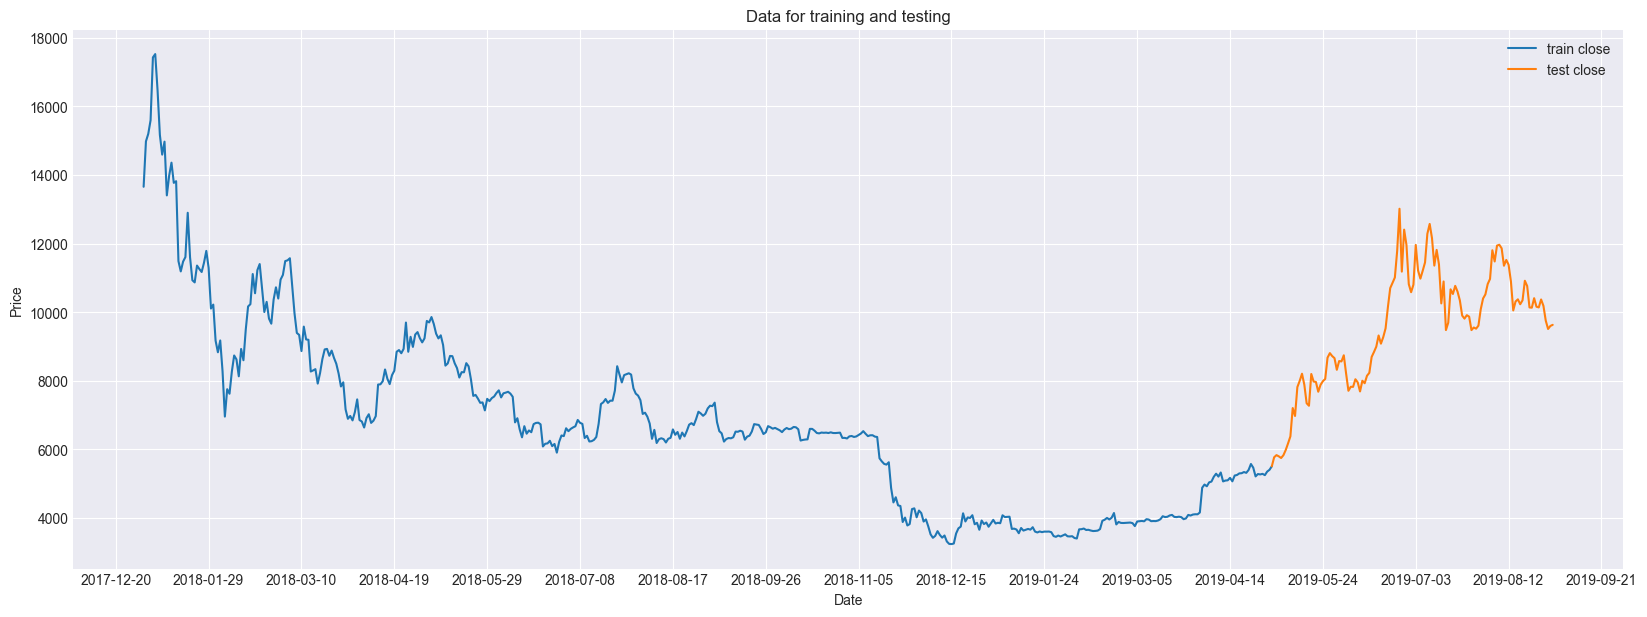

In [8]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='train close') 
plt.plot(btc_test['Adj_Close'],label='test close') 

plt.title('Data for training and testing') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

#### 3. Scaling the data for training and testing

In [9]:
from sklearn.preprocessing import MinMaxScaler 

In [10]:
np.random.seed(0) 
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(btc_adjClose)    

#### 4. Reshaping the scaled data for LSTM Network

In [11]:
x_train, y_train = [],[] 
for i in range(80,len(btc_train)):
    x_train.append(scaled_data[i-80:i,0]) 
    y_train.append(scaled_data[i,0]) 
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape 

(407, 80, 1)

#### 5. Defining and fitting LSTM Network

In [12]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM 

In [13]:
model = Sequential() 
model.add(LSTM(units=13,return_sequences=True,input_shape=(x_train.shape[1],1))) 
model.add(LSTM(units=3)) 
model.add(Dense(1)) 
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 13)            780       
                                                                 
 lstm_1 (LSTM)               (None, 3)                 204       
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 988 (3.86 KB)
Trainable params: 988 (3.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy']) 
model.fit(x_train,y_train,epochs=13,batch_size=1,verbose=2) 


Epoch 1/13


407/407 - 8s - loss: 0.0021 - accuracy: 0.0025 - 8s/epoch - 21ms/step
Epoch 2/13
407/407 - 6s - loss: 0.0015 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 3/13
407/407 - 6s - loss: 0.0012 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 4/13
407/407 - 6s - loss: 0.0011 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 5/13
407/407 - 6s - loss: 8.5468e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 6/13
407/407 - 6s - loss: 7.9948e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 7/13
407/407 - 6s - loss: 7.0217e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 8/13
407/407 - 6s - loss: 6.5558e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 9/13
407/407 - 6s - loss: 5.4661e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 10/13
407/407 - 6s - loss: 5.5034e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 11/13
407/407 - 6s - loss: 5.3749e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 12/13
407/407 - 6s - loss: 4.6990e-04 - accuracy: 0.0025 - 6s/epoch - 

#### 6. Prediction using the trained LSTM model

Calculating the index from which data is to be taken. This calculation returns the last [len(btc_test)+80] datapoints from the dataset btc_adjClose. reshape is used to reshape the input array to have one column and appropriate number of rows. Scaler expects a 2-D array of format [n_samples,n_features]. These inputs are transformed by MinMax scaler that transforms the values to a range of [0,1] to ensure that the data used for prediction is in the same format as that of data used for training

In [21]:
indice = len(btc_adjClose)-len(btc_test)-80   
inputs = btc_adjClose[indice:].values 
inputs = inputs.reshape(-1,1) 
inputs = scaler.transform(inputs) 

C:\Users\vidya\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [22]:
inputs.shape 

(202, 1)

In [23]:
x_test = [] 
for i in range(80,inputs.shape[0]):
    x_test.append(inputs[i-80:i,0]) 
x_test = np.array(x_test) 
print(f'Shape of x_test: ',x_test.shape) 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) 
print(f'Shape of x_test for LSTM: ',x_test.shape) 
close_price_predicted = model.predict(x_test) 
close_price_predicted = scaler.inverse_transform(close_price_predicted) 

Shape of x_test:  (122, 80)
Shape of x_test for LSTM:  (122, 80, 1)
4/4 [==============================] - 0s 8ms/step


#### 7. Evaluating the predictions 

In [24]:
# RMSE for LSTM
rmse = np.sqrt(np.mean(np.power((btc_test['Adj_Close'].values-close_price_predicted),2)))
print(f'RMSE for LSTM : {rmse:.6f}') 

# MAPE for LSTM
mape = np.mean(np.abs(close_price_predicted-btc_test['Adj_Close'].values)/np.abs(btc_test['Adj_Close'].values)) 
print(f'MAPE for LSTM : {mape:.6f}') 

# MPE for LSTM 
mpe = np.mean((close_price_predicted-btc_test['Adj_Close'].values)/btc_test['Adj_Close'].values) 
print(f'MPE for LSTM : {mpe:.6f}')   

RMSE for LSTM : 2412.309254
MAPE for LSTM :0.213580
MPE for LSTM : -0.004065


#### 8. Correlation between actual values and predicted via LSTM

In [25]:
btc_test['LSTM_Predictions'] = close_price_predicted 

corr_LSTM = np.corrcoef(btc_test['LSTM_Predictions'].dropna().values,btc_test['Adj_Close'].dropna().values)[0,1] 
print(f'correlation btw test-closing and LSTM-predicted-closing : {corr_LSTM*100:.2f}%')  

correlation btw test-closing and LSTM-predicted-closing : 95.75%


<ipython-input-25-f55b50b2cf31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_test['LSTM_Predictions'] = close_price_predicted


#### 9. Plotting the predictions from LSTM w.r.t Test values

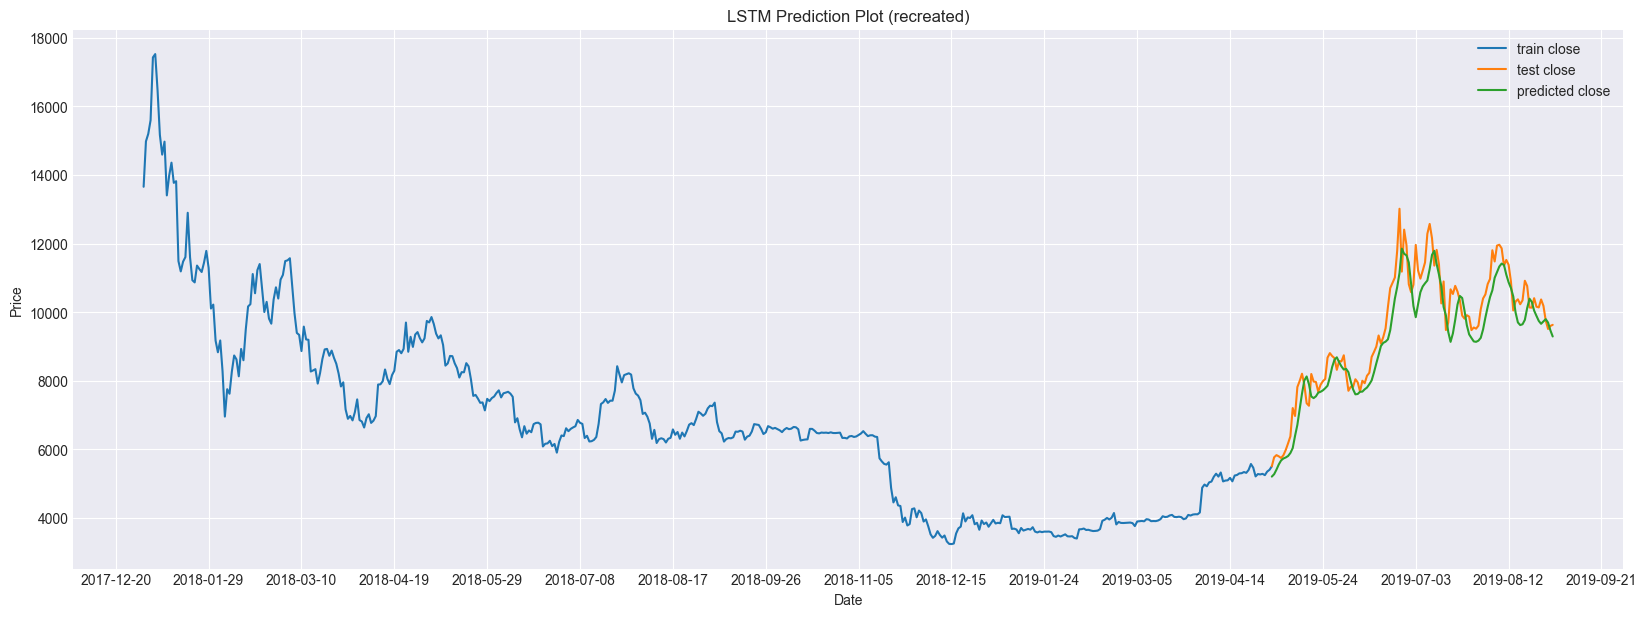

In [26]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='train close') 
plt.plot(btc_test['Adj_Close'],label='test close') 
plt.plot(btc_test['LSTM_Predictions'],label='predicted close') 
plt.title('LSTM Prediction Plot (recreated)') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  